In [51]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels as sm
%matplotlib inline

In [2]:
wildlife = pd.read_csv('../clean_data/wildlife_clean.csv', parse_dates=['CALL_SAVED_TIME'])

In [4]:
wildlife.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152743 entries, 0 to 152742
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Unnamed: 0       152743 non-null  int64         
 1   CALL_REGION      152743 non-null  object        
 2   CALL_SAVED_TIME  152672 non-null  datetime64[ns]
 3   CA_ANIMAL_TYPE   152743 non-null  object        
 4   reason_for_call  152743 non-null  object        
 5   type_of_calls    152743 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 7.0+ MB


In [5]:
wildlife.head()

,Unnamed: 0,CALL_REGION,CALL_SAVED_TIME,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
0,0,Central,2020-01-01,Deer,rescue,report_calls
1,1,Central,2020-01-01,Deer,rescue,report_calls
2,2,Central,2020-01-01,Deer,rescue,report_calls
3,3,Aberdeen,2020-01-01,Wild Bird,injury,report_calls
4,4,Central,2020-01-01,Gull,injury,report_calls


# Prediction of injuries calls

In [26]:
wildlife_injuries = wildlife[wildlife['reason_for_call']=='injury'].copy()
df_time = wildlife_injuries.groupby(['CALL_SAVED_TIME']).count()
df_time

,Unnamed: 0,CALL_REGION,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
CALL_SAVED_TIME,,,,,
2018-01-01,34,34,34,34,34
2018-01-02,33,33,33,33,33
2018-01-03,44,44,44,44,44
2018-01-04,29,29,29,29,29
2018-01-05,44,44,44,44,44
...,...,...,...,...,...
2020-04-26,101,101,101,101,101
2020-04-27,93,93,93,93,93
2020-04-28,85,85,85,85,85


In [27]:
df_time.shape

(851, 5)

In [28]:
# to find 20% of all rows
851 *0.2
851 - 170

681

In [29]:
train=df_time[0:681] 
test=df_time[681:]

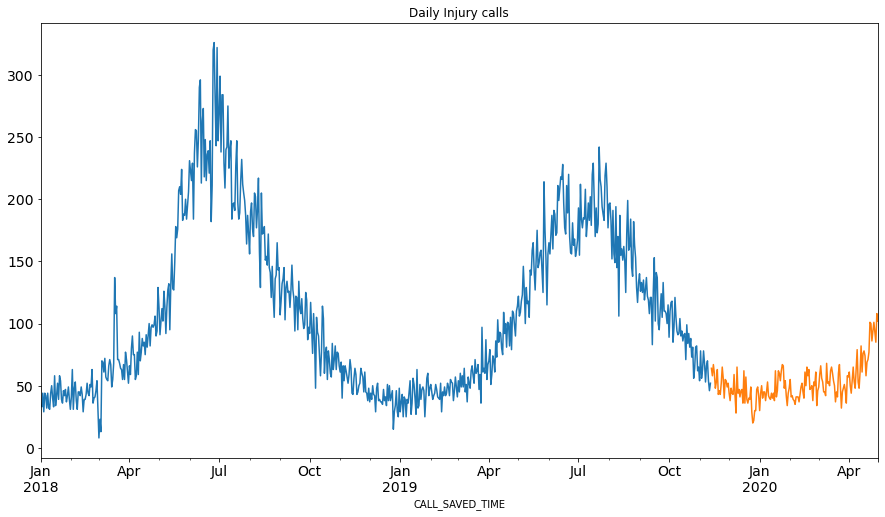

In [31]:
train.reason_for_call.plot(figsize=(15,8), title= 'Daily Injury calls', fontsize=14)
test.reason_for_call.plot(figsize=(15,8), title= 'Daily Injury calls', fontsize=14)
plt.show()

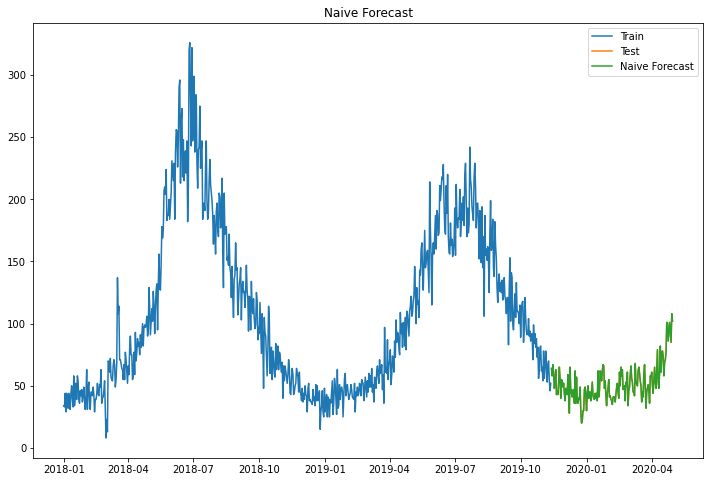

In [39]:
dd= np.asarray(train.reason_for_call)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['reason_for_call'], label='Train')
plt.plot(test.index,test['reason_for_call'], label='Test')
plt.plot(y_hat.index,y_hat['reason_for_call'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat.naive))
print(rms)

15.38907175276549


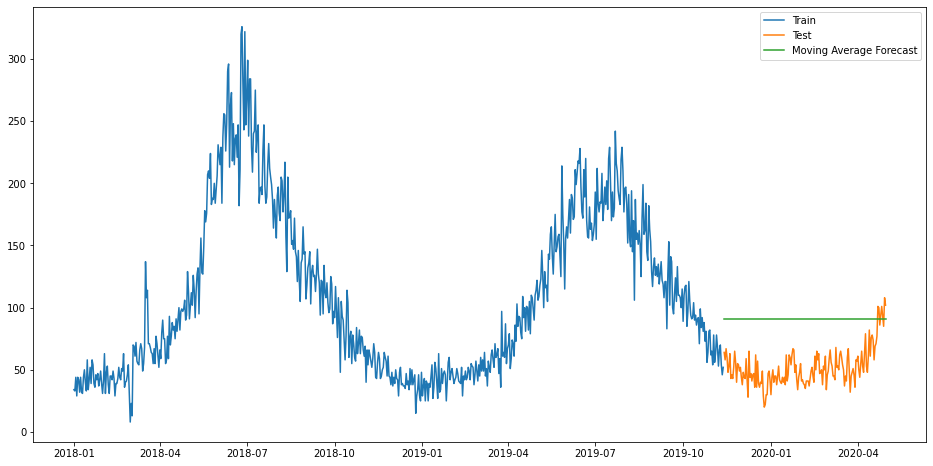

In [45]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['reason_for_call'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [47]:
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.moving_avg_forecast))
print(rms)

41.42863321818374


In [55]:
test

,Unnamed: 0,CALL_REGION,CA_ANIMAL_TYPE,reason_for_call,type_of_calls
CALL_SAVED_TIME,,,,,
2019-11-13,64,64,64,64,64
2019-11-14,58,58,58,58,58
2019-11-15,67,67,67,67,67
2019-11-16,60,60,60,60,60
2019-11-17,48,48,48,48,48
...,...,...,...,...,...
2020-04-26,101,101,101,101,101
2020-04-27,93,93,93,93,93
2020-04-28,85,85,85,85,85


/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


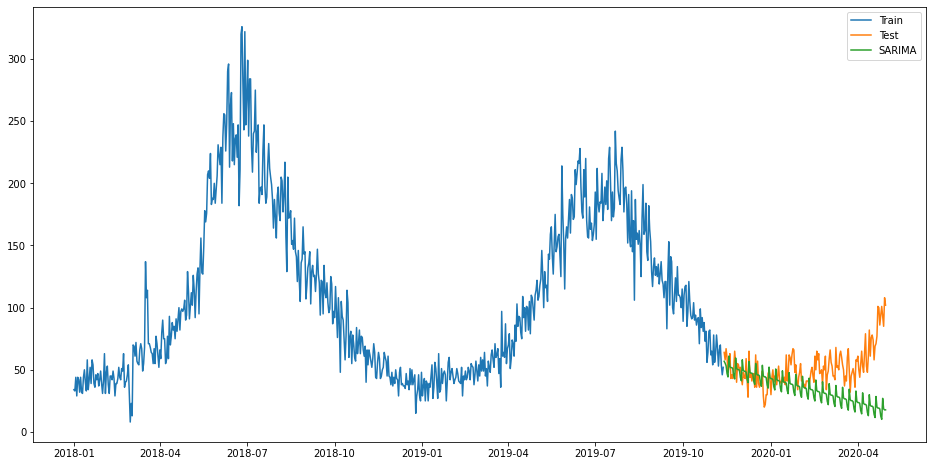

In [56]:
import statsmodels.api as sm

y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.reason_for_call, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2019-11-13", end="2020-04-30", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [58]:
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.SARIMA))
print(rms)

28.64877055381391


/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


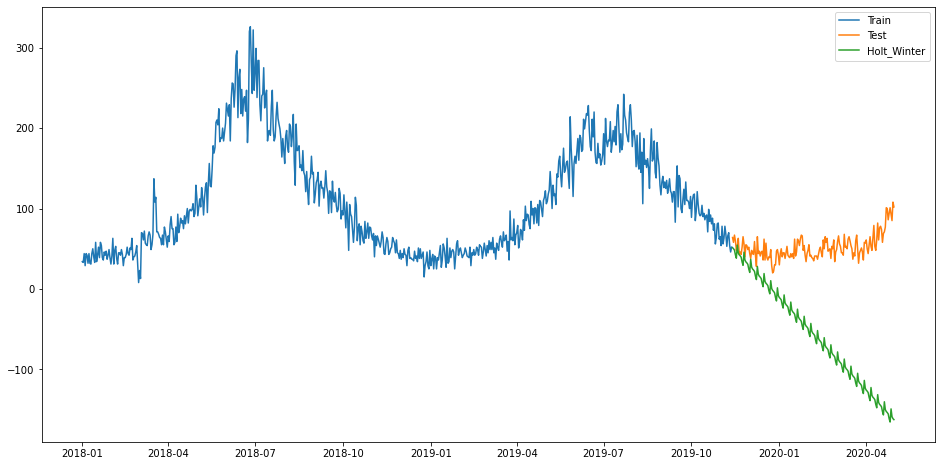

In [59]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['reason_for_call']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['reason_for_call'], label='Train')
plt.plot(test['reason_for_call'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [62]:
rms = sqrt(mean_squared_error(test.reason_for_call, y_hat_avg.Holt_Winter))
print(rms)

129.42287974757105


In [ ]:
sarima (seasonal arima)
seasonal naive
